<a href="https://colab.research.google.com/github/Nam-SW/badword_check/blob/master/bad_word_check.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install hgtk

  Created wheel for hgtk: filename=hgtk-0.1.3-py2.py3-none-any.whl size=6689 sha256=e2eed4152ef2477fd70e3e3b35805d79b36d0169da29fe3a18274c8c9f0e3e80
  Stored in directory: /root/.cache/pip/wheels/73/72/06/6065a57fe68264f35d7e52e37f56831eb3e9ec75656880de20
Successfully built hgtk


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')
base_url = '/content/gdrive/My Drive/project/badword/'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
LOG_DIR = base_url + 'tensorboard_log'

!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

import os
if not os.path.exists(LOG_DIR):
  os.makedirs(LOG_DIR)
  
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR))

get_ipython().system_raw('./ngrok http 6006 &')

!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-03-24 14:17:12--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 34.197.28.250, 34.233.35.85, 3.221.126.62, ...
Connecting to bin.equinox.io (bin.equinox.io)|34.197.28.250|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  24.7MB/s    in 0.5s    

2020-03-24 14:17:12 (24.7 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
http://19b2a657.ngrok.io


In [0]:
from collections import defaultdict
from hgtk.text import compose, decompose
from string import ascii_lowercase, ascii_uppercase


jaem = ['ㄱ', 'ㄴ', 'ㄷ', 'ㄹ', 'ㅁ', 'ㅂ', 'ㅅ', 'ㅇ', 'ㅈ', 'ㅊ', 'ㅋ', 'ㅌ', 'ㅍ', 'ㅎ', 'ㄲ', 'ㄸ', 'ㅃ', 'ㅆ', 'ㅉ', 'ㄳ', 'ㄵ', 'ㄶ', 'ㄺ', 'ㄻ', 'ㄼ', 'ㄽ', 'ㄾ', 'ㄿ', 'ㅀ', 'ㅄ']
moem = ['ㅏ', 'ㅑ', 'ㅓ', 'ㅕ', 'ㅗ', 'ㅛ', 'ㅜ', 'ㅠ', 'ㅡ', 'ㅣ', 'ㅐ', 'ㅒ', 'ㅔ', 'ㅖ', 'ㅘ', 'ㅙ', 'ㅚ', 'ㅝ', 'ㅞ', 'ㅟ', 'ㅢ']
english = list(ascii_lowercase) + list(ascii_uppercase)
sign = [s for s in ''' `~!@#$%^&*()+-/=_,.?;:'"[]{}<>\|''']

link_list = sign + jaem + moem + english + [str(i) for i in range(10)]
voc_size = len(link_list) + 1 # OOV 포함!
encoding_dict = defaultdict(lambda : 0, {k:code+1 for code, k in enumerate(link_list)}) # 0은 OOV


def encode(text):
    text = decompose(text).replace('ᴥ', '')
    code = [encoding_dict[t] for t in text]
    return code

In [0]:
import pandas as pd
import numpy as np


class Data:
    def __init__(self, maxlen):
        bad = pd.read_excel(base_url + 'badword.xlsx', encoding='utf-8-sig')
        bad.dropna(how='any', inplace=True)
        good = pd.read_excel(base_url + 'goodword.xlsx', encoding='utf-8-sig')
        good.dropna(how='any', inplace=True)

        bad_len = len(bad)
        good_len = len(good)

        if bad_len > good_len:
            good = good[:bad_len]
        else:
            bad = bad[:good_len]
        df = pd.concat([bad, good])

        X = df['data'].to_list()
        Y = df['label'].to_numpy()

        for i in range(len(X)):
            d = X[i]
            encoding = encode(d)
            if len(encoding) > maxlen:
                nplist = np.array(encoding[:maxlen])
            else:
                # nplist = np.zeros(maxlen)
                # for i in range()
                encoding = [0] * (maxlen - len(encoding)) + encoding
                nplist = np.array(encoding)

            X[i] = nplist
        
        X = np.array(X)
        # Y = df['label'].to_numpy()
        datalen = X.shape[0]

        s = np.arange(datalen)
        np.random.shuffle(s)
        X, Y = X[s], Y[s]

        slicelen = int(datalen * 0.9)
        x_train = X[:slicelen]
        y_train = Y[:slicelen]

        x_test = X[slicelen:]
        y_test = Y[slicelen:]

        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test
        self.input_shape = x_train.shape[1:]

In [6]:
from keras import layers
from keras.models import Model


def build_model(input_shape):
    # layers.Embedding(maxlen, 32, input_shape=input_size)
    input_layer = layers.Input(input_shape, name='input_layer')

    embedding = layers.Embedding(voc_size, 64)(input_layer)
    residual1 = layers.Conv1D(64, 10, name='block1_residual')(embedding)
    x1 = layers.Conv1D(64, 10, padding='same', activation='relu', name='block1_Conv1')(residual1)
    # x1 = layers.Dropout(0.2, name='block1_Dropout')(x1)
    x1 = layers.Conv1D(64, 10, padding='same', activation='relu', name='block1_Conv2')(x1)
    x1 = layers.add([residual1, x1], name='block1_add')
    x1 = layers.MaxPool1D(2, name='block1_MaxPool')(x1)

    residual2 = layers.Conv1D(32, 10, name='block2_residual')(x1)
    x2 = layers.Conv1D(32, 10, padding='same', activation='relu', name='block2_Conv1')(residual2)
    # x2 = layers.Dropout(0.2, name='block2_Dropout')(x2)
    x2 = layers.Conv1D(32, 10, padding='same', activation='relu', name='block2_Conv2')(x2)
    x2 = layers.add([residual2, x2], name='block2_add')
    x2 = layers.MaxPool1D(2, name='block2_MaxPool')(x2)
    
    # residual3 = layers.Conv1D(32, 10, name='block3_residual')(x2)
    # x3 = layers.Conv1D(32, 10, padding='same', activation='relu', name='block3_Conv1')(residual3)
    # # x3 = layers.Dropout(0.2, name='block3_Dropout')(x3)
    # x3 = layers.Conv1D(32, 10, padding='same', activation='relu', name='block3_Conv2')(x3)
    # x3 = layers.add([residual3, x3], name='block3_add')
    # x3 = layers.MaxPool1D(2, name='block3_MaxPool')(x3)
    
    # lstm = layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, name='lstm')(x3)
    lstm = layers.LSTM(32, dropout=0.1, recurrent_dropout=0.1, name='lstm')(x2)

    output_layer = layers.Dense(1, activation='sigmoid', name='output_layer')(lstm)

    m = Model(input_layer, output_layer)

    m.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return m

Using TensorFlow backend.


In [7]:
maxlen = 100
data = Data(maxlen)
model = build_model(data.input_shape)
model.summary()






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        (None, 100)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 100, 64)      9408        input_layer[0][0]                
__________________________________________________________________________________________________
block1_residual (Conv1D)        (None, 91, 64)       41024       embedding_1[0][0]                
__________________________________________________________________________

In [8]:
from keras.callbacks import TensorBoard


tbCallBack = TensorBoard(log_dir=LOG_DIR,
                         histogram_freq=1,
                         embeddings_freq=1,
                         embeddings_data=data.x_train[:200],
                        #  write_graph=True,
                        #  write_grads=True,
                        #  write_images=True,
                         )

history = model.fit(data.x_train,
                    data.y_train,
                    batch_size=5, 
                    epochs=20, 
                    validation_split=0.1, 
                    callbacks=[tbCallBack]
                    )




Train on 4671 samples, validate on 520 samples









Epoch 1/20
4671/4671 [==============================] - 47s 10ms/step - loss: 0.4468 - acc: 0.7898 - val_loss: 0.3183 - val_acc: 0.8635

Epoch 2/20
4671/4671 [==============================] - 51s 11ms/step - loss: 0.3072 - acc: 0.8900 - val_loss: 0.2470 - val_acc: 0.9173
Epoch 3/20
4671/4671 [==============================] - 45s 10ms/step - loss: 0.2490 - acc: 0.9208 - val_loss: 0.2178 - val_acc: 0.9365
Epoch 4/20
4671/4671 [==============================] - 48s 10ms/step - loss: 0.2527 - acc: 0.9214 - val_loss: 0.2364 - val_acc: 0.9250
Epoch 5/20
4671/4671 [==============================] - 47s 10ms/step - loss: 0.2483 - acc: 0.9171 - val_loss: 0.2359 - val_acc: 0.9327
Epoch 6/20
4671/4671 [==============================] - 46s 10ms/step - loss: 0.2276 - acc: 0.9274 - val_loss: 0.2262 - val_acc: 0.9308
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Epoch 7/20
4671/4671 [==================

577/577 [==============================] - 0s 775us/step
[0.6321488344070196, 0.58578856152513]


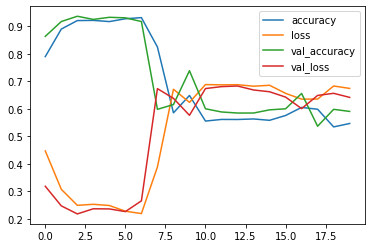

In [9]:
import matplotlib.pyplot as plt

evaluate = model.evaluate(data.x_test, data.y_test)
print(evaluate)

plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_acc'], label='val_accuracy')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

plt.show()